<a href="https://colab.research.google.com/github/Ksenyff/ICV-2024/blob/main/Week_3_Spiridonova_K_O.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3. Binary Images and Morphological Operations


In [1]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

import random
from typing import Tuple

plt.rcParams['axes.titlesize'] = 10

## Helpers

In [8]:
def add_gaussian_noise(image_gray: np.ndarray,
                       mean: float = 0, sigma: float = 16,
                       vmax: int = 255) -> np.ndarray:
  """
  Adds Gaussian noise to a grayscale image.

  Parameters:
    image_gray (np.ndarray): Input grayscale image.
    mean (float): Mean of the Gaussian noise distribution. Default is 0.
    sigma (float): Standard deviation of the Gaussian noise distribution. Default is 16.
    vmax (int): Maximum pixel intensity value (depends on image depth).
                Default is 255 for 8-bit images.

  Returns:
    np.ndarray: Image with added Gaussian noise, clipped to the valid range [0, vmax].
  """
  # Generate Gaussian noise with the specified mean and standard deviation
  gaussian_noise = np.random.normal(mean, sigma, image_gray.shape).astype(np.float32)

  # Add the generated noise to the image
  # Q: How do we handle overflow and underflow of pixel values?
  # Применяем ограничения типа min/max, отсечение, можем использовать понижающиеи/повыщающие коэфициенты
  image_noisy  = image_gray.astype(np.float32) + gaussian_noise

  # Clip the pixel values to ensure they stay within the valid range [0, vmax]
  image_noisy = np.clip(image_noisy, 0, vmax)

  return image_noisy.astype(image_gray.dtype)

In [9]:
def gen_thresh_image(width: int, height: int,
                     vbground: int, vfground: int,
                     fsize: int, ftype: str = 'square') -> np.ndarray:
  """
  Generate a grayscale image with a specified background and
    a foreground (square or circle).

  Parameters:
    width (int): Width of the image.
    height (int): Height of the image.
    vbground (int): Pixel intensity value for the background (0-255). интенсивность заднего плана
    vfground (int): Pixel intensity value for the foreground (0-255). интенсивность переднего плана
    fsize (int): Size of the foreground (square size or circle's diameter).
    ftype (str): Type of the foreground ('square' or 'circle'). Default is 'square'.

  Returns:
    np.ndarray: Generated grayscale image.  #Сгенерированное полутоновое изображение.
  """
  if ftype not in ['circle', 'square']:
    raise ValueError(f"foreground must be 'square' or 'circle': got '{ftype}'")

  # Create a blank image with the background intensity
  image = np.full((height, width), vbground, dtype=np.uint8)

  if ftype == 'square':
    # Calculate the coordinates of the top-left and bottom-right corners
    # of the foreground square
    # координаты углов изображения
    top_left = (width // 2 - fsize // 2, height // 2 - fsize // 2, )
    bottom_right = (width // 2 + fsize // 2, height // 2 + fsize // 2)

    # Draw the foreground square in the center of the image
    cv2.rectangle(image, top_left, bottom_right, vfground, -1)

  elif ftype == 'circle':
    # Calculate the center and radius of the circle
    center = (width // 2, height // 2)
    radius = fsize // 2

    # Draw the foreground circle in the center of the image
    cv2.circle(image, center, radius, vfground, -1)

  return image

## 1. Binary Thresholding

### Global Thresholding

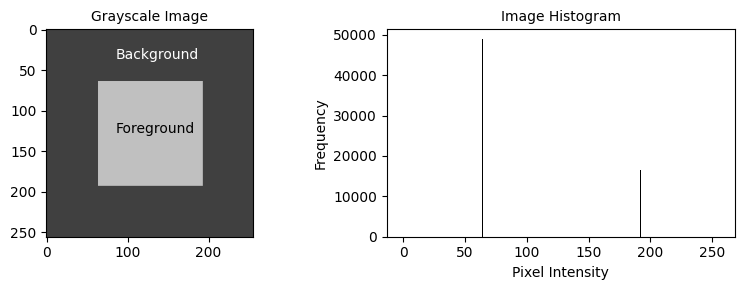

In [18]:
# Generate the image
image = gen_thresh_image(width=256, height=256, vbground=64, vfground=192,
                         fsize=128, ftype='square')

# Get the dimensions of the image for text annotations
height, width = image.shape

# Compute histogram for the image
image_hist, image_bins = np.histogram(image.flatten(), bins=256, range=(0, 256))

# Display the generated image and histogram
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title('Grayscale Image')

# Add text annotations for Background and Foreground
plt.text(width // 3, height // 7, 'Background', color='white')
plt.text(width // 3, height // 2, 'Foreground', color='black')

plt.subplot(1, 2, 2)
plt.bar(image_bins[:-1], image_hist, width=1, color='black')
plt.title('Image Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Q: Where is the background and the foreground?

Ответ: темно серый задний

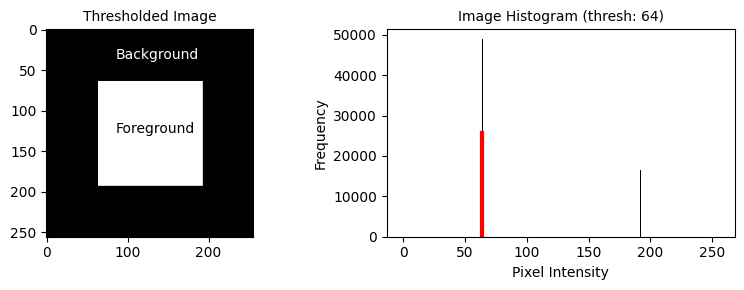

In [35]:
# Set the threshold pixel intensity (manually) ПОРОГ
# A: Try other values (e.g., 191 and 192, or 63 and 64)
vthresh = 64

# Apply binary thresholding to the image
_, image_thresh = cv2.threshold(image, vthresh, 255, cv2.THRESH_BINARY)

# image_hist, image_bins = np.histogram(image_thresh.flatten(), bins=256, range=(0, 256))

# Display the thresholded images and histogram
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.imshow(image_thresh, cmap='gray', vmin=0, vmax=255)
plt.title('Thresholded Image')

# Add text annotations for Background and Foreground
plt.text(width // 3, height // 7, 'Background', color='white')
plt.text(width // 3, height // 2, 'Foreground', color='black')

plt.subplot(1, 2, 2)
plt.bar(image_bins[:-1], image_hist, width=1, color='black')
plt.axvline(vthresh, 0, 0.5, color='red', lw=3)
plt.title(f'Image Histogram (thresh: {vthresh})')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

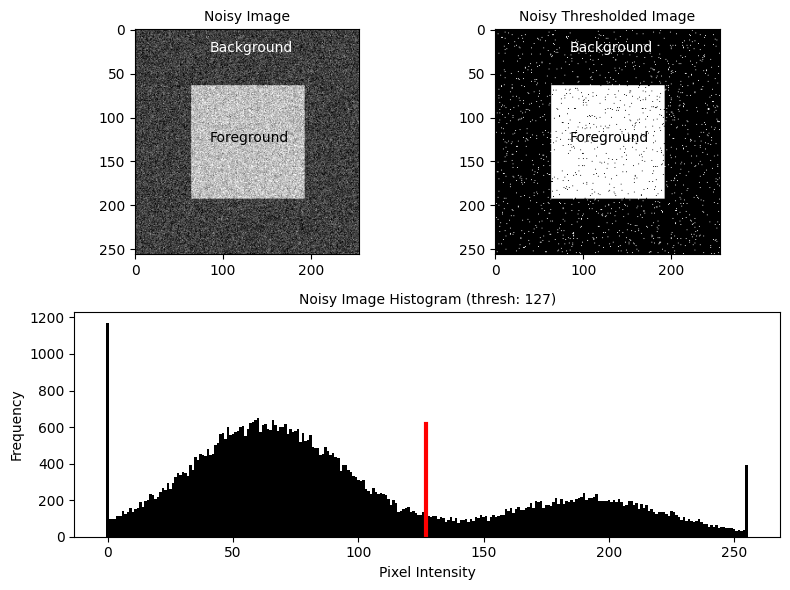

In [12]:
# Apply Gaussian noise to the image
image_noisy = add_gaussian_noise(image, mean=0, sigma=32)

# Apply binary thresholding on the noisy image
_, image_thresh_noisy = \
  cv2.threshold(image_noisy, vthresh, 255, cv2.THRESH_BINARY)

# Compute the histogram for the noisy image
image_noisy_hist, image_noisy_bins = \
  np.histogram(image_noisy.flatten(), bins=256, range=(0, 256))

# Display the noisy image, thresholded image, and histogram
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.imshow(image_noisy, cmap='gray', vmin=0, vmax=255)
plt.title('Noisy Image')

plt.text(height // 3, 25, 'Background', color='white')
plt.text(height // 3, width // 2, 'Foreground', color='black')

plt.subplot(2, 2, 2)
plt.imshow(image_thresh_noisy, cmap='gray', vmin=0, vmax=255)
plt.title('Noisy Thresholded Image')

plt.text(height // 3, 25, 'Background', color='white')
plt.text(height // 3, width // 2, 'Foreground', color='black')

plt.subplot(2, 1, 2)
plt.bar(image_noisy_bins[:-1], image_noisy_hist, width=1, color='black')
plt.axvline(vthresh, 0, 0.5, color='red', lw=3)
plt.title(f'Noisy Image Histogram (thresh: {vthresh})')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

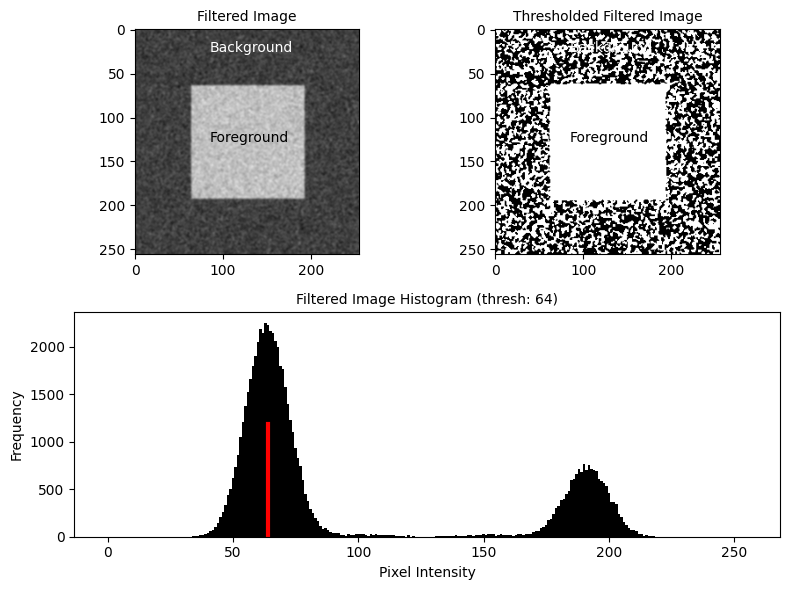

In [36]:
# Apply Gaussian blur to the noisy image
image_filtered = cv2.GaussianBlur(image_noisy, (5, 5), 0)

# Apply thresholding on the filtered image
_, image_filtered_thresh = \
  cv2.threshold(image_filtered, vthresh, 255, cv2.THRESH_BINARY)

# Compute the histogram for the filtered image
image_filtered_hist, image_filtered_bins = \
  np.histogram(image_filtered.flatten(), bins=256, range=(0, 256))

# Display the filtered image, thresholded image, and histogram
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.imshow(image_filtered, cmap='gray', vmin=0, vmax=255)
plt.title('Filtered Image')

plt.text(height // 3, 25, 'Background', color='white')
plt.text(height // 3, width // 2, 'Foreground', color='black')

plt.subplot(2, 2, 2)
plt.imshow(image_filtered_thresh, cmap='gray', vmin=0, vmax=255)
plt.title('Thresholded Filtered Image')

plt.text(height // 3, 25, 'Background', color='white')
plt.text(height // 3, width // 2, 'Foreground', color='black')

plt.subplot(2, 1, 2)
plt.bar(image_filtered_bins[:-1], image_filtered_hist, width=1, color='black')
plt.axvline(vthresh, 0, 0.5, color='red', lw=3)
plt.title(f'Filtered Image Histogram (thresh: {vthresh})')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Q: How does filtering (Gaussian blurring) affect the noisy image?

Ответ: 1) Уменьшение шума
2) Сглаживание изображения
3) Сохранение деталей

### Otsu's Thresholding

In **global thresholding**, we used an arbitrary chosen value as a threshold. In contrast, **Otsu's method** avoids having to choose a value and **determines it automatically**.

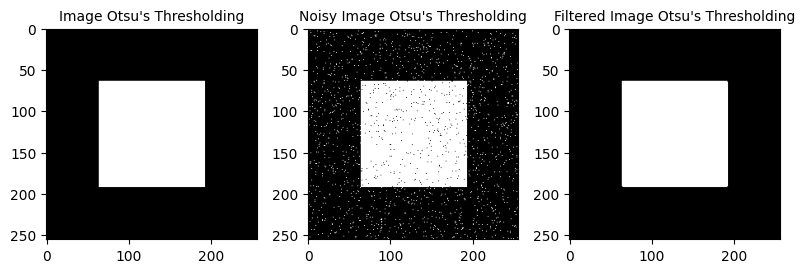

In [37]:
# Apply Otsu's thresholding on the original image
_, thresh_otsu = \
  cv2.threshold(image, None, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Apply Otsu's thresholding on the noisy image
_, thresh_otsu_noisy = \
  cv2.threshold(image_noisy, None, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Apply Otsu's thresholding on the filtered image
_, thresh_otsu_filtered = \
  cv2.threshold(image_filtered, None, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Display the thresholded images
plt.figure(figsize=(8, 3))

plt.subplot(1, 3, 1)
plt.imshow(thresh_otsu, cmap='gray', vmin=0, vmax=255)
plt.title("Image Otsu's Thresholding")

plt.subplot(1, 3, 2)
plt.imshow(thresh_otsu_noisy, cmap='gray', vmin=0, vmax=255)
plt.title("Noisy Image Otsu's Thresholding")

plt.subplot(1, 3, 3)
plt.imshow(thresh_otsu_filtered, cmap='gray', vmin=0, vmax=255)
plt.title("Filtered Image Otsu's Thresholding")

plt.tight_layout()
plt.show()

### Adaptive Thresholding

Previously, we used one global value as a threshold. But this might not be good in all cases, e.g. if an image has different lighting conditions in different areas. In that case, **adaptive thresholding** can help.

Here, the algorithm determines the threshold for a pixel based on a small region around it. So we get **different thresholds for different regions** of the same image which gives better results for images with varying illumination.


Ранее мы использовали одно глобальное значение в качестве порога. Но это может быть не во всех случаях, например, если на изображении разные условия освещения в разных областях. В этом случае может помочь адаптивное пороговое значение.

Здесь алгоритм определяет порог для пикселя на основе небольшой области вокруг него. Таким образом, мы получаем разные пороги для разных областей одного и того же изображения, что дает лучшие результаты для изображений с разной освещенностью.

In [38]:
!wget --user-agent="Mozilla/5.0" https://i.imgur.com/DjLvuLi.png -O sudoku.png

--2024-12-11 14:58:31--  https://i.imgur.com/DjLvuLi.png
Resolving i.imgur.com (i.imgur.com)... 199.232.192.193, 199.232.196.193
Connecting to i.imgur.com (i.imgur.com)|199.232.192.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255098 (249K) [image/png]
Saving to: ‘sudoku.png’

sudoku.png          100%[===================>] 249.12K  --.-KB/s    in 0.007s  

2024-12-11 14:58:31 (35.6 MB/s) - ‘sudoku.png’ saved [255098/255098]



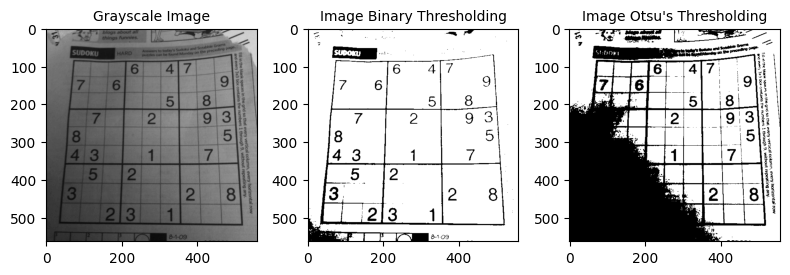

In [39]:
# Load the grayscale image
image = cv2.imread('sudoku.png', cv2.IMREAD_GRAYSCALE)

# Apply binary thresholding with a fixed threshold
_, thresh_binary = \
  cv2.threshold(image, 50, 255, cv2.THRESH_BINARY)

# Apply Otsu's thresholding
# Note: we can set the threshold to 0 or None for Otsu's thresholding
_, thresh_otsu = \
  cv2.threshold(image, None, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(8, 6))

plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title("Grayscale Image")

plt.subplot(2, 3, 2)
plt.imshow(thresh_binary, cmap='gray', vmin=0, vmax=255)
plt.title("Image Binary Thresholding")

plt.subplot(2, 3, 3)
plt.imshow(thresh_otsu, cmap='gray', vmin=0, vmax=255)
plt.title("Image Otsu's Thresholding")

plt.tight_layout()
plt.show()

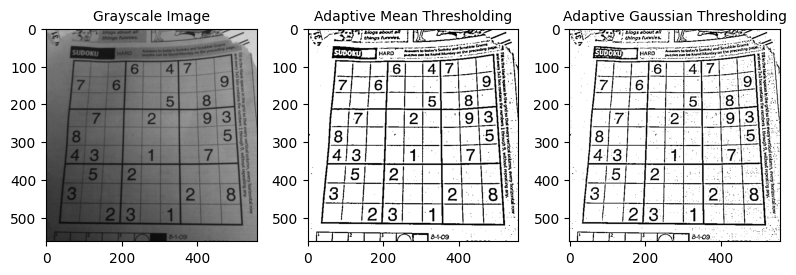

In [17]:
# Apply Adaptive Mean Thresholding
thresh_adapt_mean = cv2.adaptiveThreshold(
    image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,
    blockSize=11, C=6
)

# Apply Adaptive Gaussian Thresholding
thresh_adapt_gauss = cv2.adaptiveThreshold(
    image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, blockSize=11, C=4
)

plt.figure(figsize=(8, 6))

plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title("Grayscale Image")

plt.subplot(2, 3, 2)
plt.imshow(thresh_adapt_mean, cmap='gray', vmin=0, vmax=255)
plt.title("Adaptive Mean Thresholding")

plt.subplot(2, 3, 3)
plt.imshow(thresh_adapt_gauss, cmap='gray', vmin=0, vmax=255)
plt.title("Adaptive Gaussian Thresholding")

plt.tight_layout()
plt.show()

## 2. Morphological Operations

### Structuring Elements

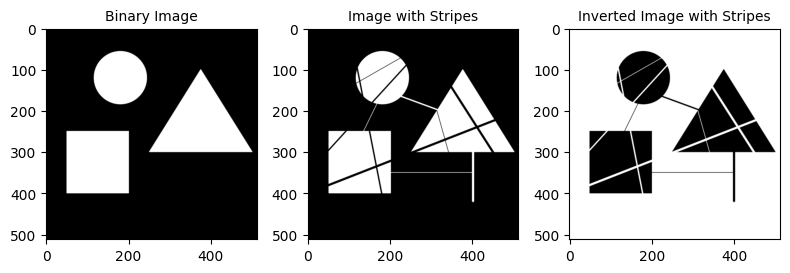

In [ ]:
# Create a blank binary image filled with black
image = np.full(shape=(512, 512), fill_value=0, dtype=np.uint8)

# Draw a filled white circle
cv2.circle(image, center=(180, 120), radius=64,
           color=255, thickness=-1, lineType=cv2.LINE_AA)

# Draw a filled white rectangle
cv2.rectangle(image, pt1=(50, 250), pt2=(200, 400),
              color=255, thickness=-1, lineType=cv2.LINE_AA)

# Draw a filled white triangle
triangle_points = np.array([[250, 300], [375, 100], [500, 300]])
cv2.fillPoly(image, pts=[triangle_points], color=255, lineType=cv2.LINE_AA)

# Make a copy of the image to add black stripes
image_stripes = image.copy()

# Draw anti-aliased black lines from different points on the edges
cv2.line(
    image_stripes,
    pt1=(0, 200),
    pt2=(350, 0),
    color=0,
    thickness=1,
    lineType=cv2.LINE_AA
)
cv2.line(image_stripes, (320, 0), (0, 350), 0, 2, cv2.LINE_AA)
cv2.line(image_stripes, (256, 0), (400, 512), 0, 1, cv2.LINE_AA)
cv2.line(image_stripes, (256, 0), (512, 400), 0, 3, cv2.LINE_AA)
cv2.line(image_stripes, (100, 0), (200, 512), 0, 2, cv2.LINE_AA)
cv2.line(image_stripes, (0, 400), (512, 200), 0, 3, cv2.LINE_AA)

# Draw lines connecting the shapes
cv2.line(image_stripes, (180, 156), (100, 320), 255, 1, cv2.LINE_AA)
cv2.line(image_stripes, (200, 156), (320, 200), 255, 2, cv2.LINE_AA)
cv2.line(image_stripes, (400, 300), (400, 420), 255, 3, cv2.LINE_AA)
cv2.line(image_stripes, (200, 350), (400, 350), 255, 1, cv2.LINE_AA)

# Invert the binary image
image_stripes_inv = cv2.bitwise_not(image_stripes)

# Display the binary image
plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title('Binary Image')

plt.subplot(1, 3, 2)
plt.imshow(image_stripes, cmap='gray', vmin=0, vmax=255)
plt.title('Image with Stripes')

plt.subplot(1, 3, 3)
plt.imshow(image_stripes_inv, cmap='gray', vmin=0, vmax=255)
plt.title('Inverted Image with Stripes')

plt.tight_layout()
plt.show()

Q: How to get rid of black lines?

- **Erosion** reduces the size of white regions (foreground) in a binary image by eroding away the boundaries of the object. It is commonly used to remove small noise and detach objects that are slightly connected.
- **Dilation** increases the size of white regions (foreground) by expanding the boundaries of the object. It is used to close small gaps in the foreground object.

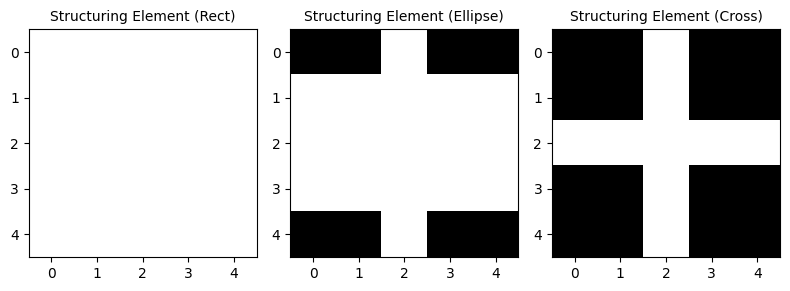

In [ ]:
# Define kernel size
ksize = 5

# Note: the kernel consists of only 0s and 1s

# Rectangular kernel: treats all pixels in the rectangular neighborhood equally
kernel_rect = cv2.getStructuringElement(
    shape=cv2.MORPH_RECT, ksize=(ksize, ksize)
)

# Elliptical kernel: less aggressive than the rectangular kernel
# and preserves the roundness of objects more effectively
kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))

# Cross-shaped kernel: less aggressive than the rectangular kernel
# and more selective since only the cross-shaped neighborhood is affected
kernel_cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (ksize, ksize))

# Display the structuring elements
plt.figure(figsize=(8, 3))

plt.subplot(1, 3, 1)
plt.imshow(kernel_rect, cmap='gray', vmin=0, vmax=1)
plt.title("Structuring Element (Rect)")

plt.subplot(1, 3, 2)
plt.imshow(kernel_ellipse, cmap='gray', vmin=0, vmax=1)
plt.title("Structuring Element (Ellipse)")

plt.subplot(1, 3, 3)
plt.imshow(kernel_cross, cmap='gray', vmin=0, vmax=1)
plt.title("Structuring Element (Cross)")

plt.tight_layout()
plt.show()

### Erosion and Dilation

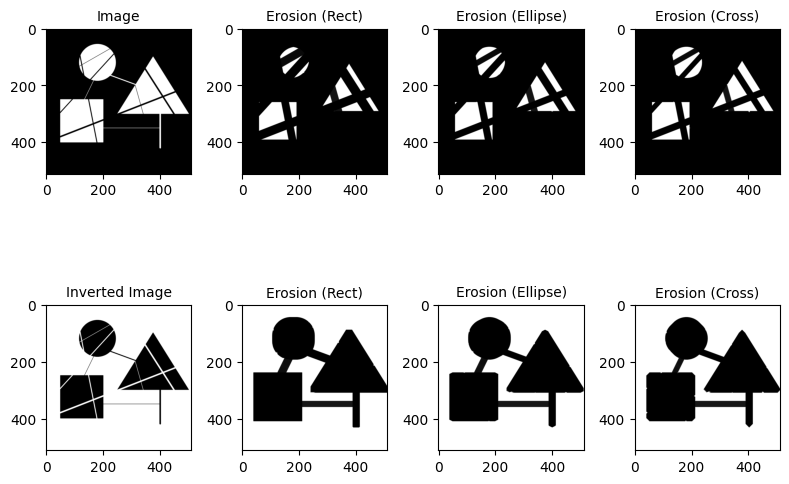

In [ ]:
# Define the number of iterations
iters = 5

# Apply erosion with different kernels on the original binary image
image_eroded_rect = cv2.erode(
    image_stripes, kernel=kernel_rect, iterations=iters
)
image_eroded_ellipse = cv2.erode(image_stripes, kernel_ellipse, iterations=iters)
image_eroded_cross = cv2.erode(image_stripes, kernel_cross, iterations=iters)

# Apply erosion with different kernels on the inverted binary image
image_inv_eroded_rect = cv2.erode(image_stripes_inv, kernel_rect, iterations=iters)
image_inv_eroded_ellipse = cv2.erode(image_stripes_inv, kernel_ellipse, iterations=iters)
image_inv_eroded_cross = cv2.erode(image_stripes_inv, kernel_cross, iterations=iters)

# Display the results
plt.figure(figsize=(8, 6))

# Original binary image erosion results
plt.subplot(2, 4, 1)
plt.imshow(image_stripes, cmap='gray', vmin=0, vmax=255)
plt.title("Image")

plt.subplot(2, 4, 2)
plt.imshow(image_eroded_rect, cmap='gray', vmin=0, vmax=255)
plt.title("Erosion (Rect)")

plt.subplot(2, 4, 3)
plt.imshow(image_eroded_ellipse, cmap='gray', vmin=0, vmax=255)
plt.title("Erosion (Ellipse)")

plt.subplot(2, 4, 4)
plt.imshow(image_eroded_cross, cmap='gray', vmin=0, vmax=255)
plt.title("Erosion (Cross)")

# Inverted binary image erosion results
plt.subplot(2, 4, 5)
plt.imshow(image_stripes_inv, cmap='gray', vmin=0, vmax=255)
plt.title("Inverted Image")

plt.subplot(2, 4, 6)
plt.imshow(image_inv_eroded_rect, cmap='gray', vmin=0, vmax=255)
plt.title("Erosion (Rect)")

plt.subplot(2, 4, 7)
plt.imshow(image_inv_eroded_ellipse, cmap='gray', vmin=0, vmax=255)
plt.title("Erosion (Ellipse)")

plt.subplot(2, 4, 8)
plt.imshow(image_inv_eroded_cross, cmap='gray', vmin=0, vmax=255)
plt.title("Erosion (Cross)")

plt.tight_layout()
plt.show()

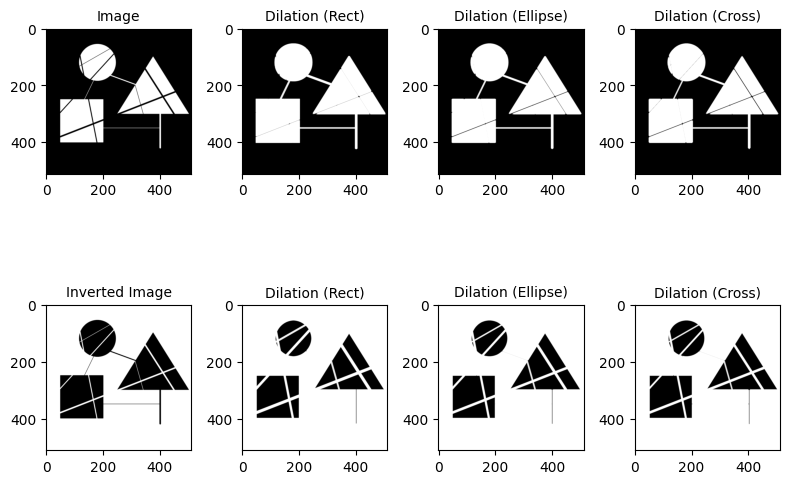

In [ ]:
# Define the number of iterations
iters = 1

# Apply dilation with different kernels on the original binary image
image_dilated_rect = cv2.dilate(
    image_stripes, kernel=kernel_rect, iterations=iters
)
image_dilated_ellipse = cv2.dilate(image_stripes, kernel_ellipse, iterations=iters)
image_dilated_cross = cv2.dilate(image_stripes, kernel_cross, iterations=iters)

# Apply erosion with different kernels on the inverted binary image
image_inv_dilated_rect = cv2.dilate(image_stripes_inv, kernel_rect, iterations=iters)
image_inv_dilated_ellipse = cv2.dilate(image_stripes_inv, kernel_ellipse, iterations=iters)
image_inv_dilated_cross = cv2.dilate(image_stripes_inv, kernel_cross, iterations=iters)

# Display the results
plt.figure(figsize=(8, 6))

# Original binary image dilation results
plt.subplot(2, 4, 1)
plt.imshow(image_stripes, cmap='gray', vmin=0, vmax=255)
plt.title("Image")

plt.subplot(2, 4, 2)
plt.imshow(image_dilated_rect, cmap='gray', vmin=0, vmax=255)
plt.title("Dilation (Rect)")

plt.subplot(2, 4, 3)
plt.imshow(image_dilated_ellipse, cmap='gray', vmin=0, vmax=255)
plt.title("Dilation (Ellipse)")

plt.subplot(2, 4, 4)
plt.imshow(image_dilated_cross, cmap='gray', vmin=0, vmax=255)
plt.title("Dilation (Cross)")

# Inverted binary image dilation results
plt.subplot(2, 4, 5)
plt.imshow(image_stripes_inv, cmap='gray', vmin=0, vmax=255)
plt.title("Inverted Image")

plt.subplot(2, 4, 6)
plt.imshow(image_inv_dilated_rect, cmap='gray', vmin=0, vmax=255)
plt.title("Dilation (Rect)")

plt.subplot(2, 4, 7)
plt.imshow(image_inv_dilated_ellipse, cmap='gray', vmin=0, vmax=255)
plt.title("Dilation (Ellipse)")

plt.subplot(2, 4, 8)
plt.imshow(image_inv_dilated_cross, cmap='gray', vmin=0, vmax=255)
plt.title("Dilation (Cross)")

plt.tight_layout()
plt.show()

### Open and Close

In [ ]:
def add_cross_noise(image: np.ndarray, num_crosses: int = 10,
                    color: str = 'white', font_scale: float = 1.0,
                    thickness: int = 1, grid_size: int = 50) -> np.ndarray:
  """
  Adds random cross (+) text noise to a binary image.

  Parameters:
    image (np.ndarray): The binary image to which cross noise will be added.
    num_crosses (int): The number of crosses to add to the image.
    color (str): Color of the crosses. Can be 'white' or 'black'.
    font_scale (float): Scale of the cross text.
    thickness (int): Thickness of the cross text.
    grid_size (int): Size of each grid cell to evenly distribute the crosses.

  Returns:
    np.ndarray: The binary image with added cross noise.
  """
  # Copy the original image to avoid modifying it
  noisy_image = image.copy()
  height, width = noisy_image.shape

  # Determine the color of the crosses (0 for black, 255 for white)
  cross_color = 0 if color == 'black' else 255

  # Create a list of possible grid centers based on the grid size
  possible_positions = [
      (
        x + random.randint(-grid_size//2, grid_size//2),
        y + random.randint(-grid_size//2, grid_size//2)
      )
        for x in range(grid_size, width, grid_size)
          for y in range(grid_size, height, grid_size)
  ]

  # Shuffle the list to randomize the cross placement
  random.shuffle(possible_positions)

  # Limit the number of crosses to the minimum of num_crosses or available grid positions
  num_crosses = min(num_crosses, len(possible_positions))

  for i in range(num_crosses):
    # Choose a position from the grid
    position = possible_positions[i]

    # Add the cross symbol ('+') at the selected position
    cv2.putText(noisy_image, '+', position,
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale,
                color=cross_color, thickness=thickness, lineType=cv2.LINE_AA)

  return noisy_image


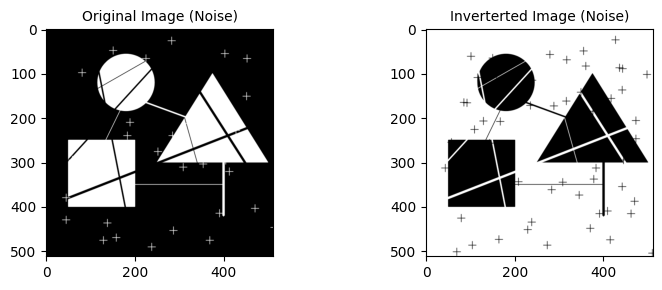

In [ ]:
# Define the thickness of the cross noise
cross_thickness = 1

# Add white cross noise to the binary image
image_noisy = add_cross_noise(
    image_stripes, num_crosses=32,
    color='white', thickness=cross_thickness
)

# Add black cross noise to the binary image
image_noisy_inv = add_cross_noise(
    image_stripes_inv, num_crosses=64,
    color='black',thickness=cross_thickness
)

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.imshow(image_noisy, cmap='gray', vmin=0, vmax=255)
plt.title('Original Image (Noise)')

plt.subplot(1, 2, 2)
plt.imshow(image_noisy_inv, cmap='gray', vmin=0, vmax=255)
plt.title('Inverterted Image (Noise)')

plt.tight_layout()
plt.show()

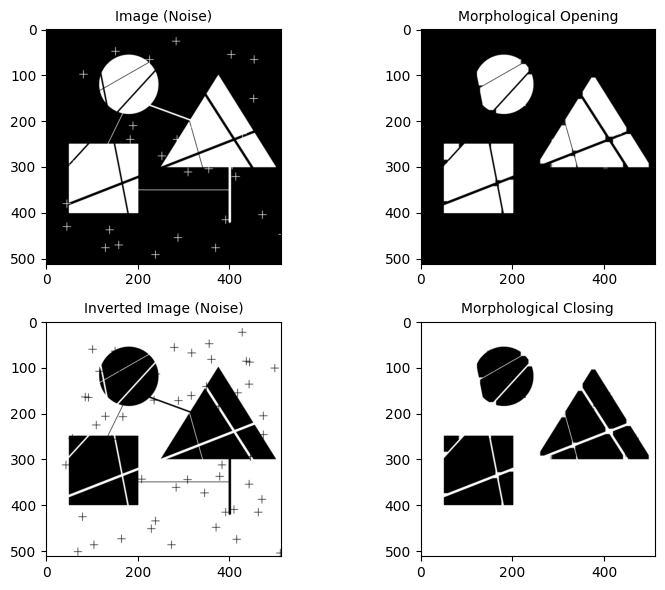

In [ ]:
# Define the number of iterations and kernel for morphological operations
iters = 2
kernel = kernel_rect

# Perform morphological opening (erosion followed by dilation)
image_opened = cv2.morphologyEx(
    image_noisy, op=cv2.MORPH_OPEN, kernel=kernel,
    iterations=iters
)

# Perform morphological closing (dilation followed by erosion)
image_inv_closed = cv2.morphologyEx(
    image_noisy_inv, op=cv2.MORPH_CLOSE, kernel=kernel,
    iterations=iters
)

plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.imshow(image_noisy, cmap='gray', vmin=0, vmax=255)
plt.title('Image (Noise)')

plt.subplot(2, 2, 2)
plt.imshow(image_opened, cmap='gray', vmin=0, vmax=255)
plt.title('Morphological Opening')

plt.subplot(2, 2, 3)
plt.imshow(image_noisy_inv, cmap='gray', vmin=0, vmax=255)
plt.title('Inverted Image (Noise)')

plt.subplot(2, 2, 4)
plt.imshow(image_inv_closed, cmap='gray', vmin=0, vmax=255)
plt.title('Morphological Closing')

plt.tight_layout()
plt.show()

### Gradient

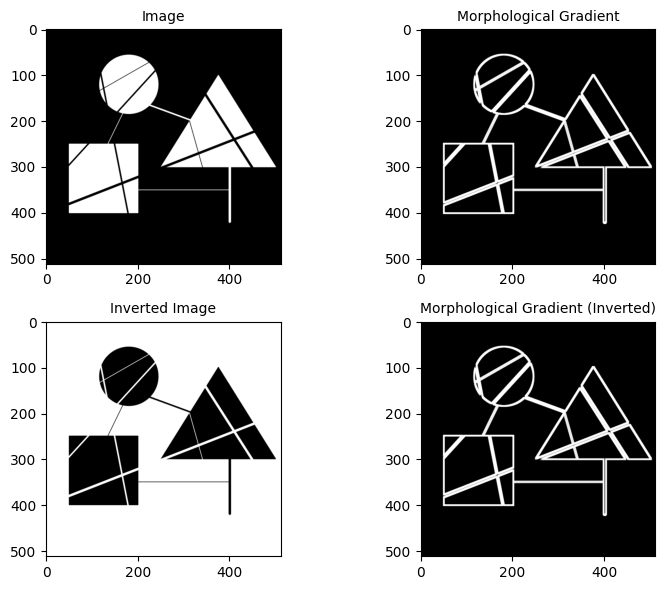

In [ ]:
# Define the number of iterations and kernel for morphological operations
iters = 1
kernel = kernel_rect

# Perform morphological gradient (difference between dilation and erosion)
image_gradient = cv2.morphologyEx(
    image_stripes, op=cv2.MORPH_GRADIENT, kernel=kernel,
    iterations=iters
)

# Perform morphological gradient on the inverted image
image_inv_gradient = cv2.morphologyEx(
    image_stripes_inv, op=cv2.MORPH_GRADIENT, kernel=kernel,
    iterations=iters
)

plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.imshow(image_stripes, cmap='gray', vmin=0, vmax=255)
plt.title('Image')

plt.subplot(2, 2, 2)
plt.imshow(image_gradient, cmap='gray', vmin=0, vmax=255)
plt.title('Morphological Gradient')

plt.subplot(2, 2, 3)
plt.imshow(image_stripes_inv, cmap='gray', vmin=0, vmax=255)
plt.title('Inverted Image')

plt.subplot(2, 2, 4)
plt.imshow(image_inv_gradient, cmap='gray', vmin=0, vmax=255)
plt.title('Morphological Gradient (Inverted)')

plt.tight_layout()
plt.show()

### Top (White) Hat and Black Hat

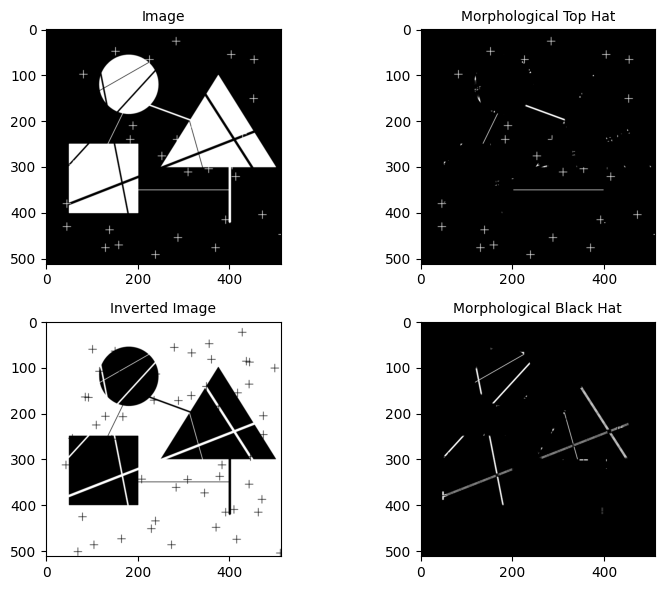

In [ ]:
image_top_hat = cv2.morphologyEx(image_noisy, cv2.MORPH_TOPHAT, kernel_rect)
image_black_hat = cv2.morphologyEx(image_noisy, cv2.MORPH_BLACKHAT, kernel_rect)

plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.imshow(image_noisy, cmap='gray', vmin=0, vmax=255)
plt.title('Image')

plt.subplot(2, 2, 2)
plt.imshow(image_top_hat, cmap='gray', vmin=0, vmax=255)
plt.title('Morphological Top Hat')

plt.subplot(2, 2, 3)
plt.imshow(image_noisy_inv, cmap='gray', vmin=0, vmax=255)
plt.title('Inverted Image')

plt.subplot(2, 2, 4)
plt.imshow(image_black_hat, cmap='gray', vmin=0, vmax=255)
plt.title('Morphological Black Hat')

plt.tight_layout()
plt.show()

### Hit-or-Miss

This example demonstrates how to use the **hit-or-miss morphological** transformation to detect specific patterns in a binary image, which is useful for shape or pattern detection.

The hit-or-miss operation detects a specific configuration of pixels using a kernel:
- **Foreground pixels** (1s): these must exactly match the corresponding pixels in the image.
- **Background pixels** (0s): these must match the complement of the corresponding pixels in the image.
- **Don't care pixels** (-1s): these pixels are ignored during the matching process.

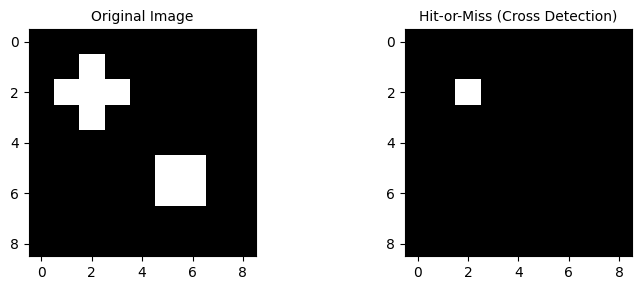

In [ ]:
# Create a binary image with different shapes
binary_image = np.zeros((9, 9), dtype=np.uint8)

# Draw some patterns: a cross, a square, and some random shapes
binary_image[1:4, 2] = 1  # vertical part of the cross
binary_image[2, 1:4] = 1  # horizontal part of the cross
binary_image[5:7, 5:7] = 1  # small square

# Define the hit-or-miss kernel for detecting a cross pattern
# Kernel to detect a cross:
#  - center pixel must be 1
#  - neighbors above, below, left, and right must also be 1
kernel_hit_or_miss = np.array([
    [-1, 1, -1],
    [ 1, 1,  1],
    [-1, 1, -1]
], dtype=np.int8)

# Step 3: Apply the hit-or-miss operation using cv2.morphologyEx
hit_or_miss = cv2.morphologyEx(
  binary_image, cv2.MORPH_HITMISS, kernel_hit_or_miss
)

# Step 4: Display the original and processed images
plt.figure(figsize=(8, 3))

# Original Binary Image
plt.subplot(1, 2, 1)
plt.imshow(binary_image, cmap='gray', vmin=0, vmax=1)
plt.title('Original Image')

# Hit-or-Miss Result
plt.subplot(1, 2, 2)
plt.imshow(hit_or_miss, cmap='gray', vmin=0, vmax=1)
plt.title('Hit-or-Miss (Cross Detection)')

plt.tight_layout()
plt.show()

**Explanation**: the result highlights where the cross pattern exists.

## Claswork: Morphological Operations

Objective: Apply various morphological operations on binary and grayscale images using the `skimage.morphology` module. This will help you explore concepts like **erosion**, **dilation**, **opening**, **closing**, and **skeletonization**.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, io, color
from skimage.data import binary_blobs

# Import your libraries here ...

Load a binary or grayscale image. You can use your own image or download one from `skimage.data`:

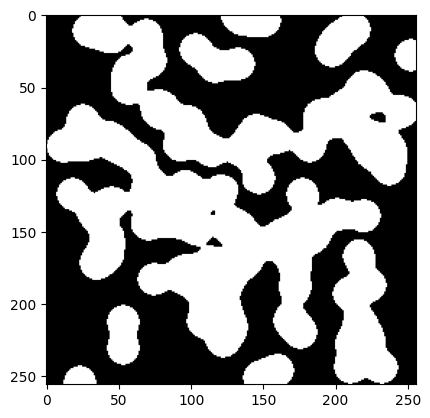

In [ ]:
image = binary_blobs(length=256)

plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
eroded = morphology.erosion(image, morphology.disk(3))
dilated = morphology.dilation(image, morphology.disk(3))
opened = morphology.opening(image, morphology.disk(3))
closed = morphology.closing(image, morphology.disk(3))

Compare the results of skeletonization and thinning. How do they differ?

In [ ]:
skeleton = morphology.skeletonize(image)
thinned = morphology.thin(image)

In [ ]:
cleaned = morphology.remove_small_objects(image, min_size=50)

Use structuring elements of different shapes (*disk*, *square*, *diamond*) and sizes.

Analyze how the results change when you modify the shape and size of the structuring element.

Download and use a real image (from the internet or take a photo of something).


In [ ]:
image = io.imread('path_to_image', as_gray=True)

# Convert to binary (or use a binary image)

## 3. Connected Components

**Connected Components** are groups of pixels in a binary image that share the same value (1 or 0) and are connected to each other either through 4-connectivity or 8-connectivity.

The process of identifying and labeling these components helps in object detection, segmentation, and feature extraction in images.

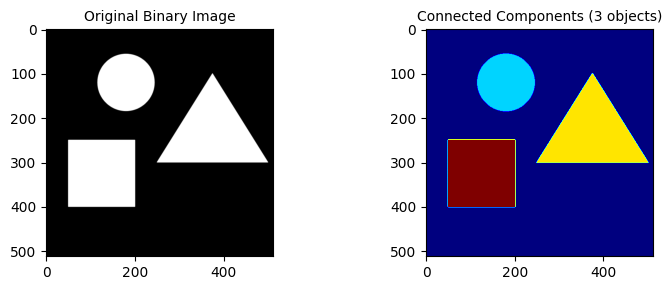

In [ ]:
# Find connected components
num_labels, labels = cv2.connectedComponents(image)

# Visualize the labeled components (each component is assigned a different color)

# Display the original and labeled components
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title('Original Binary Image')

plt.subplot(1, 2, 2)
plt.imshow(labels, cmap='jet')
plt.title(f'Connected Components ({num_labels - 1} objects)')

plt.tight_layout()
plt.show()

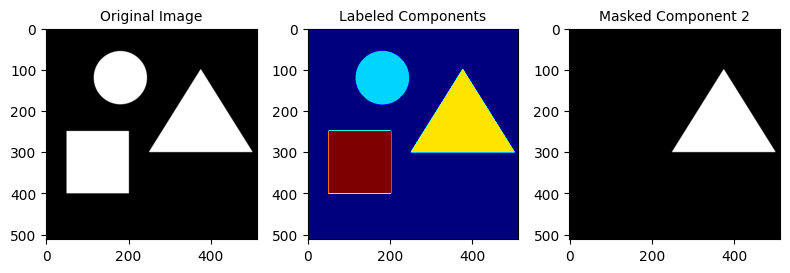

In [ ]:
# Specify the component to mask (e.g., component 2)
component_to_mask = 2

# Create a mask for the selected component
mask = np.zeros_like(image)

# Set pixels of the selected component to 255 (white)
mask[labels == component_to_mask] = 255

# Apply the mask to the original image (to highlight the component)
masked_image = cv2.bitwise_and(image, image, mask=mask)

# Display the original, labeled, and masked images
plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(labels, cmap='jet')
plt.title('Labeled Components')

plt.subplot(1, 3, 3)
plt.imshow(masked_image, cmap='gray', vmin=0, vmax=255)
plt.title(f'Masked Component {component_to_mask}')

plt.tight_layout()
plt.show()

## 4. Image Moments

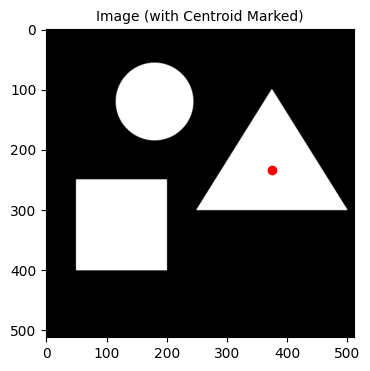

Area (M00): 6492247.0
Centroid: (375, 233)


In [ ]:
# Calculate image moments
moments = cv2.moments(masked_image)

# Calculate the centroid
cx = int(moments['m10'] / moments['m00'])
cy = int(moments['m01'] / moments['m00'])

# Display the binary image and the centroid
plt.figure(figsize=(4, 4))

plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.scatter(cx, cy, color='red')
plt.title('Image (with Centroid Marked)')
plt.show()

# Print out some basic moments
print(f"Area (M00): {moments['m00']}")
print(f"Centroid: ({cx}, {cy})")

In [ ]:
def calculate_orientation(mask: np.ndarray) -> Tuple[float, np.ndarray]:
  """
  Calculate the orientation of a binary object using image moments.

  Parameters:
  mask (np.ndarray): A binary mask of the object.

  Returns:
  Tuple[float, np.ndarray]: The orientation in degrees and the major axis eigenvector.
  """
  # Calculate central moments
  moments = cv2.moments(mask)

  # Calculate covariance matrix elements from the central moments
  mu20 = moments['mu20']
  mu02 = moments['mu02']
  mu11 = moments['mu11']

  # Construct the covariance matrix
  covariance_matrix = np.array([[mu20, mu11], [mu11, mu02]])

  # Check if the covariance matrix is valid (non-zero determinant)
  if np.isclose(np.linalg.det(covariance_matrix), 0):
    # If the covariance matrix is degenerate, the orientation is undefined
    print("Warning: Covariance matrix is degenerate. Orientation may be undefined.")
    return None, None

  # Compute eigenvalues and eigenvectors of the covariance matrix
  eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

  # The orientation corresponds to the eigenvector with the largest eigenvalue
  largest_eigenvalue_index = np.argmax(eigenvalues)
  major_axis_eigenvector = eigenvectors[:, largest_eigenvalue_index]

  # Calculate the angle of orientation (in radians)
  orientation = np.degrees(
      np.arctan2(major_axis_eigenvector[1], major_axis_eigenvector[0])
  )

  return orientation, major_axis_eigenvector

In [ ]:
def rotate_image(image: np.ndarray, angle: float,
                 center: Tuple[int, int]) -> np.ndarray:
  """
  Rotates an image around a specified center by a given angle.

  Parameters:
  image (np.ndarray): The input binary mask image.
  angle (float): The angle by which to rotate the image (in degrees).
  center (tuple): The center of rotation (cx, cy).

  Returns:
  np.ndarray: The rotated image.
  """
  # Get the dimensions of the image
  height, width = image.shape

  # Create the rotation matrix
  rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale=1.0)

  # Apply the rotation using warpAffine
  rotated_image = cv2.warpAffine(
      image, rotation_matrix, (width, height),
      flags=cv2.INTER_NEAREST, borderValue=0
  )

  return rotated_image

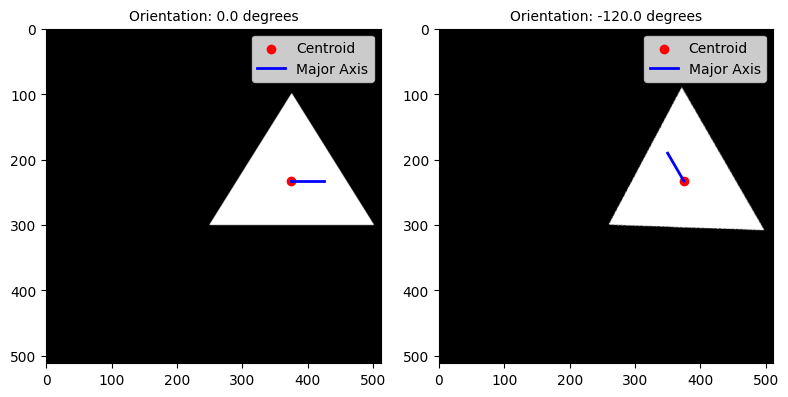

In [ ]:
# Rotate the mask around the centroid (by 120 degrees)
masked_image_rot = rotate_image(masked_image, 120, (cx, cy))

# Calculate the orientation for the original and rotate images
orientation, eigenvector = calculate_orientation(masked_image)
orientation_rot, eigenvector_rot = calculate_orientation(masked_image_rot)

plt.figure(figsize=(8, 4))

# Display the masked image
plt.subplot(1, 2, 1)
plt.imshow(masked_image, cmap='gray', vmin=0, vmax=255)
plt.scatter(cx, cy, color='red', label='Centroid')

# Draw the major axis using the eigenvector
length = 50  # Length of the orientation vector for visualization
x_axis = [cx, cx + int(length * eigenvector[0])]
y_axis = [cy, cy + int(length * eigenvector[1])]

plt.plot(x_axis, y_axis, color='blue', linewidth=2, label='Major Axis')
plt.title(f'Orientation: {orientation:.1f} degrees')
plt.legend()

# Display the rotated masked image
plt.subplot(1, 2, 2)
plt.imshow(masked_image_rot, cmap='gray', vmin=0, vmax=255)
plt.scatter(cx, cy, color='red', label='Centroid')

x_axis = [cx, cx + int(length * eigenvector_rot[0])]
y_axis = [cy, cy + int(length * eigenvector_rot[1])]

plt.plot(x_axis, y_axis, color='blue', linewidth=2, label='Major Axis')
plt.title(f'Orientation: {orientation_rot:.1f} degrees')
plt.legend()

plt.tight_layout()
plt.show()